In [5]:
# import gensim
import collections
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.contrib.tensorboard.plugins import projector

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_chunked

from tqdm import tnrange, tqdm_notebook
import scipy
from scipy.spatial.distance import cosine, pdist

from itertools import compress


### Set-up and get data

In [6]:
DATADIR = os.getenv("DATADIR")


In [7]:
embedded_sentences = np.load('embedded_sentences' + os.path.basename(DATADIR) +
                             '.npy')


In [8]:
labelled = pd.read_csv(
    os.path.join(DATADIR, 'labelled.csv.gz'),
    compression='gzip',
    low_memory=False)


In [9]:
labelled.shape


(302474, 19)

In [10]:
taxon_id_to_base_path = dict(
    zip(labelled["taxon_id"], labelled["taxon_base_path"]))


dict

In [11]:
labelled.content_id.nunique()


206038

# Using vectors for related link generation

## remove duplicate content items for related links 



In [14]:
embedded_docs_unique = embedded_sentences[~labelled.duplicated('content_id')]


In [15]:
labelled.drop_duplicates('content_id').shape


(206038, 20)

In [16]:
labelled_unique = labelled.drop_duplicates('content_id').copy()


In [17]:
len(embedded_docs_unique)


206038

### remove fatality notices

In [18]:
labelled_unique[labelled_unique["document_type"] == "fatality_notice"].head(2)


,base_path,content_id,description,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,combined_text,taxon_id,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,brexit
87002,/government/fatalities/soldier-from-3rd-battal...,5ebe3531-7631-11e4-a3cb-005056011aef,it is with great sadness that the ministry of ...,fatality_notice,2013-11-05T20:04:00.000+00:00,en,Ministry of Defence,whitehall,warrant officer class 2 ian fisher killed in a...,warrant officer class 2 ( wo2 ) fisher deploye...,warrant officer class 2 ian fisher killed in a...,8a98b827-82ad-49b4-819e-82c208c551c4,/government/national-security,National security,Government,National security,NaN,NaN,NaN,0
179350,/government/fatalities/private-robert-hayes-ki...,5c9ccc71-7631-11e4-a3cb-005056011aef,it is with great regret that the ministry of d...,fatality_notice,2010-01-05T00:00:00.000+00:00,en,Ministry of Defence,whitehall,private robert hayes killed in afghanistan,private robert hayes (all rights reserved.) pr...,private robert hayes killed in afghanistan it ...,8ff8cf05-a6e6-4757-a896-4fabd9f3229a,/defence/working-armed-forces,Armed forces,Defence and armed forces,Armed forces,NaN,NaN,NaN,0


In [19]:
embedded_docs_unique = embedded_docs_unique[
    labelled_unique['document_type'] != 'fatality_notice']


In [20]:
labelled_unique = labelled_unique[
    labelled_unique['document_type'] != 'fatality_notice']


In [21]:
#make sure labelled_unique has an index range(labelled_unique.shape[0]) rather than keeping labelled's indices
labelled_unique.reset_index(inplace=True)


In [22]:
labelled_unique.shape


(205570, 21)

In [ ]:
embedded_docs_unique.shape


(205570, 512)

# Get related links

### Define reduce functions so that only the links selected are retained in memory
I tried out a lot of approaches to getting these links (scipy distance etc). Sklearn pairwise worked best considering RAM constraints.

In [ ]:
def get_top_20_links(D_chunk, start):
    """return only the top 20 (including self) related link indices and distance metric values
    according to distance metric"""
    top_k_indices = np.argpartition(D_chunk, range(20))[:, :20]

    return top_k_indices, D_chunk[:, top_k_indices]


In [ ]:
def get_top_20_links_without_itself(D_chunk, start):
    """return the top 19 (not including self) related link indices and distance metric values
    according to distance metric"""
    top_k_indices = np.argpartition(D_chunk, range(21))[:, 1:21]

    return top_k_indices, D_chunk[:, top_k_indices]


In [ ]:
def get_links_less_than_threshold(D_chunk, start, threshold=0.15):
    """return the top links (not including self) beneath the threshold related link indices and distance metric values
    according to distance metric"""
    top_k_indices = np.argpartition(D_chunk, range(6))[:, 1:6]
    low_threshold_indices = (D_chunk[:, top_k_indices] < threshold).reshape(
        1, 5)

    indices = top_k_indices[low_threshold_indices]
    size = indices.shape[0]

    return indices.reshape(1, size), D_chunk[:, indices.reshape(1, size)]


In [ ]:
def get_top_3_links_without_itself(D_chunk, start):
    top_k_indices = np.argpartition(D_chunk, range(21))[:, 1:4]
    return top_k_indices, D_chunk[:, top_k_indices]


### Define generators


In [ ]:
gen = pairwise_distances_chunked(
    embedded_docs_unique,
    reduce_func=get_top_20_links_without_itself,
    working_memory=0, #process each array in turn
    metric='cosine',
    n_jobs=-1)


In [ ]:
gen2 = pairwise_distances_chunked(
    embedded_docs_unique,
    reduce_func=get_top_20_links,
    working_memory=0,
    metric='cosine',
    n_jobs=-1)


## Understand the distribution of number of links at different cosine sim thresholds

In [ ]:
links_thresholds = pd.DataFrame(columns=['vector_id', 'thresholds', 'numlinks'])
for i, (_, cos_sims) in enumerate(tqdm_notebook(gen)):
    numlinks = []
    for threshold in np.arange(0, 0.42, 0.01):
        numlinks.append(cos_sims[cos_sims < threshold].shape[0])
    i_links_thresholds = pd.DataFrame({
        'vector_id':
        i,
        'thresholds':
        np.arange(0, 0.42, 0.01),
        'numlinks':
        np.asarray(numlinks).astype(int)
    })
    links_thresholds = links_thresholds.append(
        i_links_thresholds, ignore_index=True)


In [29]:
links_thresholds['numlinks'] = links_thresholds['numlinks'].astype(int)


In [30]:
links_thresholds['numlinks'].groupby(links_thresholds['thresholds']).describe()


,count,mean,std,min,25%,50%,75%,max
thresholds,,,,,,,,
0.00,2048.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0.01,2048.0,0.006836,0.136077,0.0,0.0,0.0,0.0,4.0
0.02,2048.0,0.011719,0.152681,0.0,0.0,0.0,0.0,4.0
0.03,2048.0,0.109863,0.686346,0.0,0.0,0.0,0.0,17.0
0.04,2048.0,0.504883,2.299715,0.0,0.0,0.0,0.0,20.0
0.05,2048.0,1.206543,3.709112,0.0,0.0,0.0,0.0,20.0
0.06,2048.0,2.222656,5.155258,0.0,0.0,0.0,1.0,20.0
0.07,2048.0,3.641113,6.567422,0.0,0.0,0.0,3.0,20.0
0.08,2048.0,5.286621,7.721608,0.0,0.0,1.0,8.0,20.0


# Save out lists to spot check manually

In [ ]:
labelled_unique['url'] = 'www.gov.uk' + labelled_unique.base_path


### Mainstream

In [ ]:
labelled_unique.publishing_app.value_counts()


whitehall                164479
specialist-publisher      38676
publisher                  2239
hmrc-manuals-api             75
manuals-publisher            33
smartanswers                 31
collections-publisher        30
content-publisher             5
calendars                     2
Name: publishing_app, dtype: int64

#### filter mainstream content

In [ ]:
embedded_docs_publisher = embedded_docs_unique[labelled_unique['publishing_app']
                                               == 'publisher']


In [41]:
mainstream_content_ids = labelled_unique.content_id[
    labelled_unique['publishing_app'] == 'publisher']


In [45]:
with open('mainsteam_content_ids.json', 'w') as f:
    json.dump(list(mainstream_content_ids.values), f, ensure_ascii=False)


In [ ]:
labelled_publisher = labelled_unique[labelled_unique['publishing_app'] ==
                                     'publisher']


In [ ]:
embedded_docs_publisher.shape


(2239, 512)

In [ ]:
labelled_publisher.shape


(2239, 21)

#### Instantiate mainstream generator

X = just the mainstream content but need to look for links in all content so Y = all content

In [38]:
gen_pub = pairwise_distances_chunked(
    X=embedded_docs_publisher,
    Y=embedded_docs_unique,
    reduce_func=get_top_20_links,
    working_memory=0,
    metric='cosine',
    n_jobs=-1)


#### Get links in a format useful for content people

In [ ]:
source_links = []
target_links = []
urls = pd.DataFrame(columns=['source_url', 'suggested_links', 'cosine_sims'])
for i, (indices, values) in enumerate(tqdm_notebook(gen_pub)):

    source_url = labelled_unique.iat[indices[0][0],
                                     -2]  #url is penultimate column
    target_urls = [labelled_unique.iat[i, -2] for i in indices[0]]
    #     cosine_sims = pd.Series(values)
    i_urls = pd.DataFrame({
        'source_url': source_url,
        'suggested_links': target_urls,
        'cosine_sims': values.reshape(20)
    })
    urls = urls.append(i_urls, ignore_index=True)


In [ ]:
urls.to_csv("spot_check_google_links_publisher_all.csv", index=False)


### sensitive

Need the list of sensitive urls to check these

In [ ]:
# sensitive = pd.read_csv('/Users/ellieking/Downloads/Sensitive_content.csv')

# sensitive.shape

# labelled_unique['labelled_unique_idx'] = labelled_unique.index.astype('int')

# print(labelled_unique['labelled_unique_idx'].describe())

# labelled_sens = sensitive.merge(
#     labelled_unique, left_on='URL basepath', right_on='base_path', how='inner')

# print(labelled_sens.shape)

# embedded_docs_sens = embedded_docs_unique[labelled_sens['labelled_unique_idx']]

# print(embedded_docs_sens.shape)

# gen_sens = pairwise_distances_chunked(
#     X=embedded_docs_sens,
#     Y=embedded_docs_unique,
#     reduce_func=get_top_20_links,
#     working_memory=0,
#     metric='cosine',
#     n_jobs=-1)

# source_links = []
# target_links = []
# urls = pd.DataFrame(columns=['source_url', 'suggested_links', 'cosine_sims'])
# for i, (indices, values) in enumerate(tqdm_notebook(gen_sens)):

#     source_url = labelled_unique.iat[indices[0][0],
#                                      -2]  #url is penultimate column
#     target_urls = [labelled_unique.iat[i, -2] for i in indices[0]]
#     i_urls = pd.DataFrame({
#         'source_url': source_url,
#         'suggested_links': target_urls,
#         'cosine_sims': values.reshape(20)
#     })
#     urls = urls.append(i_urls, ignore_index=True)
# urls.to_csv("spot_check_google_links_sensitive.csv", index=False)


# Generate links for experiment - ingesting into content_store
### create reduce function and generator
We actually decided to do the first experiment in with links from content closer than 0.15 (thres_gen) 
but the other types of generator are here in case needed in future experiments

In [ ]:
# gen3 = pairwise_distances_chunked(
#     X=embedded_docs_unique,
#     Y=embedded_docs_unique,
#     reduce_func=get_top_3_links_without_itself,
#     working_memory=0,
#     metric="cosine",
#     n_jobs=-1,
# )


In [ ]:
# gen = pairwise_distances_chunked(
#     embedded_docs_unique,
#     reduce_func=get_top_20_links_without_itself,
#     working_memory=0,
#     metric='cosine',
#     n_jobs=-1)


In [ ]:
def get_links_less_than_threshold(D_chunk, start, threshold=0.15):
    """return the top links (not including self) beneath the threshold related link indices and distance metric values
    according to distance metric"""
    top_k_indices = np.argpartition(D_chunk, range(6))[:, 1:6]
    low_threshold_indices = (D_chunk[:, top_k_indices] < threshold).reshape(
        1, 5)

    indices = top_k_indices[low_threshold_indices]
    size = indices.shape[0]

    return indices.reshape(1, size), D_chunk[:, indices.reshape(1, size)]


In [138]:
thres_gen = pairwise_distances_chunked(
    embedded_docs_unique,
    reduce_func=get_links_less_than_threshold,
    working_memory=0,
    metric='cosine',
    n_jobs=-1)


#### Loop through all content and save out the content_ids of closest content

In [139]:
source_links = []
target_links_threshold = []

for i, (indices, values) in enumerate(tqdm_notebook(thres_gen)):
    source_content_id = labelled_unique.iat[i, 2]
    target_content_ids = [labelled_unique.iat[i, 2] for i in indices[0]]
    source_links.append(source_content_id)
    target_links_threshold.append(target_content_ids)


/Users/ellieking/.pyenv/versions/3.6.4/envs/content-similarity-3.6.4/lib/python3.6/site-packages/sklearn/utils/__init__.py:603: UserWarning: Could not adhere to working_memory config. Currently 0MiB, 2MiB required.
  (working_memory, np.ceil(row_bytes * 2 ** -20)))


### What's the distribution of number of links in the experiment

In [157]:
pd.Series(list(map(len, target_links_threshold))).describe()


count    205570.000000
mean          3.608420
std           2.002353
min           0.000000
25%           2.000000
50%           5.000000
75%           5.000000
max           5.000000
dtype: float64

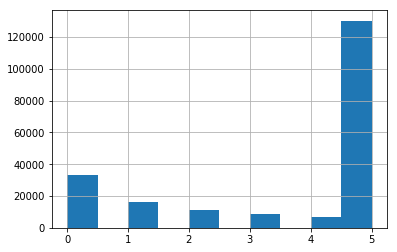

In [162]:
pd.Series(list(map(len, target_links_threshold))).hist()


In [165]:
pd.Series(list(map(len, target_links_threshold))).value_counts(normalize=True)


5    0.633847
0    0.160135
1    0.079253
2    0.053160
3    0.040808
4    0.032797
dtype: float64

16% of content will have no suggested links

In [146]:
sum(map(len, target_links_threshold)) / len(target_links_threshold) #mean number of links


3.6084204893710172

In [141]:
import json
with open('data_31JAN19_threshold_15_links.json', 'w') as f:
    json.dump(
        dict(zip(source_links, target_links_threshold)), f, ensure_ascii=False)


In [ ]:
# source_links = []
# target_links = []

# for i, (indices, values) in enumerate(tqdm_notebook(gen)):
#     print(i, indices)
#     source_content_id = labelled_unique.iat[
#         i, 2]  #assuming that content_it in 3rd column
#     target_content_ids = [labelled_unique.iat[i, 2] for i in indices[0]]
#     source_links.append(source_content_id)
#     target_links.append(target_content_ids)


In [ ]:
# import json
# with open('sample_of_data_29NOV19_all.json', 'w') as f:
#     json.dump(dict(zip(source_links, target_links)), f, ensure_ascii=False)
